# 电网数学模型emo

In [1]:
import os
print(os.path.abspath('.'))


D:\a_study\model\厂区模型


In [8]:
import numpy as np
from scipy.optimize import minimize

# 时间段数量（假设24小时）
T = 24
Δt = 1  # 时间间隔，假设为1小时

# 参数初始化
p_e_s = np.random.uniform(0.1, 0.5, T)  # EMO售出的电能的价格,在t=24的前提下，这个代码相当于生成了长度为24的数组，每个元素是0.1到0.5之间的一个随机数
L_e = np.random.uniform(10, 50, T)      # 用能侧的实际电负荷
P_BT_chr = np.random.uniform(5, 20, T)  # EMO向ESO的售电功率
P_es = np.random.uniform(5, 25, T)      # EMO从EGO的购电功率
p_e_b = np.random.uniform(0.1, 0.5, T)  # EMO从EGO的购电价格
p_g_s = np.random.uniform(0.1, 0.5, T)  # EMO向电网的售电价格
p_g_b = np.random.uniform(0.1, 0.5, T)  # EMO向电网的购电价格
P_g_s_max = 50                          # 售电功率上限
P_g_b_max = 50                          # 购电功率上限

# 目标函数
def objective(p_e_s):
    C_sell1 = p_e_s * L_e * Δt
    C_sell2 = p_e_s * P_BT_chr * Δt
    C_grid = (np.maximum(L_e - P_es, 0) * p_g_s + np.minimum(L_e - P_es, 0) * p_g_b + p_e_b * P_es) * Δt
    E_EMO = np.sum(C_sell1 + C_sell2 - C_grid)
    return -E_EMO  # 最大化E_EMO

# 约束条件
def constraints(p_e_s):
    avg_p_e_s = np.mean(p_e_s)
    cons = []

    # 电价约束
    cons.append(p_g_b - p_e_s)  # p_g_b^t < p_e_s^t
    cons.append(p_e_s - p_g_s)  # p_e_s^t < p_g_s^t
    cons.append(p_g_b - p_e_b)  # p_g_b^t < p_e_b^t
    cons.append(p_e_b - p_g_s)  # p_e_b^t < p_g_s^t

    # 平均售电价格约束
    cons.append(np.sum(p_e_s) - T * avg_p_e_s)

    return np.concatenate(cons)

# # 初始猜测值
# initial_guess = np.random.uniform(0.1, 0.5, T)

# # 约束条件字典
# constraints_dict = [{'type': 'ineq', 'fun': lambda p_e_s: con} for con in constraints(initial_guess)]

# # 求解优化问题
# result = minimize(objective, initial_guess, constraints=constraints_dict, bounds=[(0, 1)] * T)

# # 输出结果
# if result.success:
#     optimal_p_e_s = result.x
#     print(f"Optimal selling prices: {optimal_p_e_s}")
# else:
#     print("Optimization failed. Check the constraints and initial guesses.")


# 供能ego

In [7]:
import numpy as np
from scipy.optimize import minimize

# 时间段数量
T = 24

# 参数初始化
P_WT = np.random.uniform(10, 20, T)       # WT的输出功率
P_PV = np.random.uniform(5, 15, T)        # PV的输出功率
P_GT = np.random.uniform(0, 10, T)        # CCHP系统输出的电功率
P_ISAC = np.random.uniform(1, 5, T)       # ISAC的耗电功率
C_sell = np.random.uniform(0.5, 1.5, T)   # 售氢收益
F_cEGO = np.random.uniform(0.1, 0.3, T)   # 碳交易成本
a_e, b_e, c_e = 0.01, 0.1, 1              # CCHP的成本系数
c_Q, c_T = 5, 10                          # GT的启、停成本系数
Δt = 1                                    # 时间间隔，假设为1小时

# 目标函数
def objective(x):
    P_GT, I_GT_Q, I_GT_T = x[:T], x[T:2*T], x[2*T:]
    C_cchp = a_e * P_GT**2 + b_e * P_GT + c_e
    C_QT = c_Q * I_GT_Q + c_T * I_GT_T
    E_EGO = np.sum(C_sell - C_cchp - F_cEGO - C_QT)
    return -E_EGO  # 负号表示最大化

# 约束条件
def constraints(x):
    P_GT, I_GT_Q, I_GT_T = x[:T], x[T:2*T], x[2*T:]
    P_es = P_WT + P_PV + P_GT - P_ISAC
    cons = []
    cons.append(P_es)   # P_es >= 0
    return np.concatenate([c.flatten() for c in cons])

# # 初始猜测值
# initial_guess = np.concatenate([np.random.uniform(0, 10, T), np.zeros(T), np.zeros(T)])

# # 约束条件字典
# constraints_dict = [{'type': 'ineq', 'fun': lambda x, i=i: constraints(x)[i]} for i in range(len(constraints(initial_guess)))]

# # 求解优化问题
# result = minimize(objective, initial_guess, constraints=constraints_dict, bounds=[(0, 10)] * T + [(0, 1)] * (2 * T))

# # 输出结果
# if result.success:
#     optimal_solution = result.x
#     optimal_P_GT = optimal_solution[:T]
#     print(f"Optimal GT power output: {optimal_P_GT}")
# else:
#     print("Optimization failed. Check the constraints and initial guesses.")


In [5]:
import pandas as pd

# 读取Excel文件
df = pd.read_excel('15.xlsx')

# 只处理前24000行
df_subset = df.iloc[:23201]

# 用上一行的值填充缺失值
df_subset.fillna(method='ffill', inplace=True)

# 将处理后的前24000行和未处理的剩余行合并
df.iloc[:23201] = df_subset

# 将修改后的DataFrame写回Excel文件
df.to_excel('1_filled.xlsx', index=False)

print("前23201行的缺失值已填充并保存到1_filled.xlsx")



前30401行的缺失值已填充并保存到1_filled.xlsx


只考虑厂区的博弈模型：
数据使用：预测模型的发电数据、24h随即电价

电解槽模型以及状态
类定义：Electrolyzer 类用于表示电解槽及其状态。
初始化参数：包括电解槽的额定功率、启动时的电能损失系数和最低运行负荷率。
状态方法：stop、start 和 work 方法用于设置电解槽的不同状态。
状态转换：state_transition 方法根据二进制变量s、w、l来转换状态。
状态约束：single_state_constraint 方法用于确保在任意时刻电解槽只能处于一种状态。
更新状态：update 方法用于更新电解槽状态并应用约束条件。
通过这种方式，你可以模拟电解槽在不同状态下的行为，并进行进一步的优化和分析。

In [1]:
import numpy as np

class Electrolyzer:
    def __init__(self, P_max, beta_I, beta_EL_min):
        self.P_max = P_max  # 额定功率，MW
        self.beta_I = beta_I  # 启动状态时的电能损失系数
        self.beta_EL_min = beta_EL_min  # 最低运行负荷率
        
        self.S = 0  # 停机状态
        self.L = 0  # 启动状态
        self.W = 0  # 工作状态
        self.W_prev = 0  # 前一时刻工作状态
        
        self.P_H2 = 0  # 有效制氢功率，MW
        self.E_EL = 0  # 负载功率，MW
    
    def stop(self):
        self.S = 1
        self.L = 0
        self.W = 0
        self.P_H2 = 0
        self.E_EL = 0
    
    def start(self):
        self.S = 0
        self.L = 1
        self.W = 0
        self.P_H2 = 0
        self.E_EL = self.beta_I * self.P_max
    
    def work(self, E_EL):
        if E_EL < self.beta_EL_min * self.P_max or E_EL > self.P_max:
            raise ValueError("Load power out of bounds")
        
        self.S = 0
        self.L = 0
        self.W = 1
        self.P_H2 = E_EL
        self.E_EL = E_EL
    
    def state_transition(self, s, w, l):
        if s == 1 and w == 1:
            self.stop()
        elif w == 1 and l == 1:
            self.work(self.E_EL)
        elif l == 1 and s == 1:
            self.start()
        else:
            self.S = s
            self.W = w
            self.L = l
    
    def single_state_constraint(self):
        if self.S + self.L + self.W != 1:
            raise ValueError("State constraint violated")
    
    def update(self):
        self.single_state_constraint()
        if self.S == 1 and self.W_prev == 1:
            self.stop()
        elif self.L == 1 and self.S == 1:
            self.start()
        elif self.W == 1 and self.L == 1:
            self.work(self.E_EL)
        self.W_prev = self.W

# 参数设置
P_max = 100  # 额定功率，MW
beta_I = 0.2  # 启动状态时的电能损失系数
beta_EL_min = 0.1  # 最低运行负荷率

# 创建电解槽实例
electrolyzer = Electrolyzer(P_max, beta_I, beta_EL_min)

# 模拟电解槽状态转换
state_sequence = [(1, 1, 0), (0, 1, 1), (0, 0, 1)]  # (s, w, l)

for state in state_sequence:
    s, w, l = state
    electrolyzer.state_transition(s, w, l)
    electrolyzer.update()
    print(f"State: S={electrolyzer.S}, W={electrolyzer.W}, L={electrolyzer.L}")
    print(f"Power: P_H2={electrolyzer.P_H2} MW, E_EL={electrolyzer.E_EL} MW")


State: S=1, W=0, L=0
Power: P_H2=0 MW, E_EL=0 MW


ValueError: Load power out of bounds

In [2]:
# gai
import numpy as np

class Electrolyzer:
    def __init__(self, P_max, beta_I, beta_EL_min):
        self.P_max = P_max  # 额定功率，MW
        self.beta_I = beta_I  # 启动状态时的电能损失系数
        self.beta_EL_min = beta_EL_min  # 最低运行负荷率
        
        self.S = 0  # 停机状态
        self.L = 0  # 启动状态
        self.W = 0  # 工作状态
        self.W_prev = 0  # 前一时刻工作状态
        
        self.P_H2 = 0  # 有效制氢功率，MW
        self.E_EL = 0  # 负载功率，MW
    
    def stop(self):
        self.S = 1
        self.L = 0
        self.W = 0
        self.P_H2 = 0
        self.E_EL = 0
    
    def start(self):
        self.S = 0
        self.L = 1
        self.W = 0
        self.P_H2 = 0
        self.E_EL = self.beta_I * self.P_max
    
    def work(self, E_EL):
        if E_EL < self.beta_EL_min * self.P_max or E_EL > self.P_max:
            raise ValueError("Load power out of bounds")
        
        self.S = 0
        self.L = 0
        self.W = 1
        self.P_H2 = E_EL
        self.E_EL = E_EL
    
    def state_transition(self, s, w, l, E_EL=None):
        if s == 1 and w == 1:
            self.stop()
        elif w == 1 and l == 1:
            if E_EL is not None:
                self.work(E_EL)
            else:
                self.work(self.P_max)  # 默认使用最大功率
        elif l == 1 and s == 1:
            self.start()
        else:
            self.S = s
            self.W = w
            self.L = l
    
    def single_state_constraint(self):
        if self.S + self.L + self.W != 1:
            raise ValueError("State constraint violated")
    
    def update(self):
        self.single_state_constraint()
        if self.S == 1 and self.W_prev == 1:
            self.stop()
        elif self.L == 1 and self.S == 1:
            self.start()
        elif self.W == 1 and self.L == 1:
            self.work(self.E_EL)
        self.W_prev = self.W

# 参数设置
P_max = 100  # 额定功率，MW
beta_I = 0.2  # 启动状态时的电能损失系数
beta_EL_min = 0.1  # 最低运行负荷率

# 创建电解槽实例
electrolyzer = Electrolyzer(P_max, beta_I, beta_EL_min)

# 模拟电解槽状态转换
state_sequence = [
    (1, 1, 0),  # 停机
    (0, 1, 1),  # 启动
    (0, 0, 1, 50),  # 工作，50 MW
    (1, 1, 0)   # 停机
]  # (s, w, l, E_EL)

for state in state_sequence:
    s, w, l, *E_EL = state
    E_EL = E_EL[0] if E_EL else None
    electrolyzer.state_transition(s, w, l, E_EL)
    electrolyzer.update()
    print(f"State: S={electrolyzer.S}, W={electrolyzer.W}, L={electrolyzer.L}")
    print(f"Power: P_H2={electrolyzer.P_H2} MW, E_EL={electrolyzer.E_EL} MW")


State: S=1, W=0, L=0
Power: P_H2=0 MW, E_EL=0 MW
State: S=0, W=1, L=0
Power: P_H2=100 MW, E_EL=100 MW
State: S=0, W=0, L=1
Power: P_H2=100 MW, E_EL=100 MW
State: S=1, W=0, L=0
Power: P_H2=0 MW, E_EL=0 MW


In [ ]:
# gai2


import numpy as np

class Electrolyzer:
    def __init__(self, P_max, beta_I, beta_EL_min, switch_cost, lifetime_cost):
        self.P_max = P_max  # 额定功率，MW
        self.beta_I = beta_I  # 启动状态时的电能损失系数
        self.beta_EL_min = beta_EL_min  # 最低运行负荷率
        
        self.switch_cost = switch_cost  # 状态切换成本
        self.lifetime_cost = lifetime_cost  # 寿命成本
        
        self.S = 0  # 停机状态
        self.L = 0  # 启动状态
        self.W = 0  # 工作状态
        self.W_prev = 0  # 前一时刻工作状态
        
        self.P_H2 = 0  # 有效制氢功率，MW
        self.E_EL = 0  # 负载功率，MW
        
        self.lifetime = 0  # 电解槽使用寿命
        self.total_cost = 0  # 总成本
    
    def stop(self):
        self.S = 1
        self.L = 0
        self.W = 0
        self.P_H2 = 0
        self.E_EL = 0
        self.total_cost += self.switch_cost
    
    def start(self):
        self.S = 0
        self.L = 1
        self.W = 0
        self.P_H2 = 0
        self.E_EL = self.beta_I * self.P_max
        self.total_cost += self.switch_cost
    
    def work(self, E_EL):
        if E_EL < self.beta_EL_min * self.P_max or E_EL > self.P_max:
            raise ValueError("Load power out of bounds")
        
        self.S = 0
        self.L = 0
        self.W = 1
        self.P_H2 = E_EL
        self.E_EL = E_EL
        self.total_cost += self.lifetime_cost
        self.lifetime += 1
    
    def state_transition(self, s, w, l, E_EL=None):
        if s == 1 and w == 1:
            self.stop()
        elif w == 1 and l == 1:
            if E_EL is not None:
                self.work(E_EL)
            else:
                self.work(self.P_max)  # 默认使用最大功率
        elif l == 1 and s == 1:
            self.start()
        else:
            self.S = s
            self.W = w
            self.L = l
    
    def single_state_constraint(self):
        if self.S + self.L + self.W != 1:
            raise ValueError("State constraint violated")
    
    def update(self):
        self.single_state_constraint()
        if self.S == 1 and self.W_prev == 1:
            self.stop()
        elif self.L == 1 and self.S == 1:
            self.start()
        elif self.W == 1 and self.L == 1:
            self.work(self.E_EL)
        self.W_prev = self.W

# 参数设置
P_max = 100  # 额定功率，MW
beta_I = 0.2  # 启动状态时的电能损失系数
beta_EL_min = 0.1  # 最低运行负荷率
switch_cost = 10  # 状态切换成本，假设为10单位
lifetime_cost = 5  # 每次工作状态下的寿命成本，假设为5单位








# 创建电解槽组
num_electrolyzers = 8
electrolyzers = [Electrolyzer(P_max, beta_I, beta_EL_min, switch_cost, lifetime_cost) for _ in range(num_electrolyzers)]

# 初始状态设定
initial_states = [(0, 0, 1, 50) for _ in range(4)] + [(0, 1, 1) for _ in range(2)] + [(1, 1, 0) for _ in range(2)]

for i, state in enumerate(initial_states):
    s, w, l, *E_EL = state
    E_EL = E_EL[0] if E_EL else None
    electrolyzers[i].state_transition(s, w, l, E_EL)
    electrolyzers[i].update()

# 输出初始状态
for i, electrolyzer in enumerate(electrolyzers):
    print(f"Electrolyzer {i+1}:")
    print(f"  State: S={electrolyzer.S}, W={electrolyzer.W}, L={electrolyzer.L}")
    print(f"  Power: P_H2={electrolyzer.P_H2} MW, E_EL={electrolyzer.E_EL} MW")
    print(f"  Total Cost: {electrolyzer.total_cost}, Lifetime: {electrolyzer.lifetime}")

# 模拟电解槽组的状态转换
state_sequences = [
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 50), (1, 1, 0)],
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 70), (1, 1, 0)],
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 90), (1, 1, 0)],
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 60), (1, 1, 0)],
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 80), (1, 1, 0)],
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 50), (1, 1, 0)],
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 70), (1, 1, 0)],
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 90), (1, 1, 0)]
]  # 每个电解槽的状态序列 (s, w, l, E_EL)

for i, state_sequence in enumerate(state_sequences):
    print(f"Electrolyzer {i+1}:")
    for state in state_sequence:
        s, w, l, *E_EL = state
        E_EL = E_EL[0] if E_EL else None
        electrolyzers[i].state_transition(s, w, l, E_EL)
        electrolyzers[i].update()
        print(f"  State: S={electrolyzers[i].S}, W={electrolyzers[i].W}, L={electrolyzers[i].L}")
        print(f"  Power: P_H2={electrolyzers[i].P_H2} MW, E_EL={electrolyzers[i].E_EL} MW")
        print(f"  Total Cost: {electrolyzers[i].total_cost}, Lifetime: {electrolyzers[i].lifetime}")


电网，包括售电

In [ ]:
class PowerGrid:
    def __init__(self, buy_prices, sell_prices):
        self.buy_prices = buy_prices
        self.sell_prices = sell_prices
    
    def get_price(self, t):
        buy_price = self.buy_prices[t]
        sell_price = self.sell_prices[t]
        return buy_price, sell_price
    
    def calculate_cost(self, power_demand, power_generated, t):
        buy_price, sell_price = self.get_price(t)
        if power_demand > power_generated:
            power_needed = power_demand - power_generated
            cost = power_needed * buy_price
            return cost, 0
        else:
            power_surplus = power_generated - power_demand
            revenue = power_surplus * sell_price
            return 0, revenue

代码说明
类定义：Electrolyzer 类添加了 switch_cost 和 lifetime_cost 属性，用于表示状态切换成本和寿命成本。
方法修改：
stop 方法和 start 方法中增加了状态切换成本的累加。
work 方法中增加了寿命成本的累加和使用寿命的增加。
初始状态设定：通过 initial_states 设置电解槽组的初始状态。
模拟状态转换：通过 state_sequences 模拟每个电解槽的状态转换，并输出状态和成本信息。
这个模型能够帮助你分析电解槽组在不同状态下的运行成本和寿命管理，从而优化整体的运行策略

不加寿命的

In [1]:
import numpy as np

class Electrolyzer:
    def __init__(self, P_max, beta_I, beta_EL_min):
        self.P_max = P_max  # 额定功率，MW
        self.beta_I = beta_I  # 启动状态时的电能损失系数
        self.beta_EL_min = beta_EL_min  # 最低运行负荷率
        
        self.S = 0  # 停机状态
        self.L = 0  # 启动状态
        self.W = 0  # 工作状态
        self.W_prev = 0  # 前一时刻工作状态
        
        self.P_H2 = 0  # 有效制氢功率，MW
        self.E_EL = 0  # 负载功率，MW
    
    def stop(self):
        self.S = 1
        self.L = 0
        self.W = 0
        self.P_H2 = 0
        self.E_EL = 0
    
    def start(self):
        self.S = 0
        self.L = 1
        self.W = 0
        self.P_H2 = 0
        self.E_EL = self.beta_I * self.P_max
    
    def work(self, E_EL):
        if E_EL < self.beta_EL_min * self.P_max or E_EL > self.P_max:
            raise ValueError("Load power out of bounds")
        
        self.S = 0
        self.L = 0
        self.W = 1
        self.P_H2 = E_EL  # 有效制氢功率等于负载功率
        self.E_EL = E_EL
    
    def state_transition(self, s, w, l, E_EL=None):
        if s == 1 and w == 1:
            self.stop()
        elif w == 1 and l == 1:
            if E_EL is not None:
                self.work(E_EL)
            else:
                self.work(self.P_max)  # 默认使用最大功率
        elif l == 1 and s == 1:
            self.start()
        else:
            self.S = s
            self.W = w
            self.L = l
    
    def single_state_constraint(self):
        if self.S + self.L + self.W != 1:
            raise ValueError("State constraint violated")  # 违反状态约束
    
    def update(self):
        self.single_state_constraint()
        if self.S == 1 and self.W_prev == 1:
            self.stop()
        elif self.L == 1 and self.S == 1:
            self.start()
        elif self.W == 1 and self.L == 1:
            self.work(self.E_EL)
        self.W_prev = self.W

# 参数设置
P_max = 100  # 额定功率，MW
beta_I = 0.2  # 启动状态时的电能损失系数
beta_EL_min = 0.1  # 最低运行负荷率

# 创建电解槽组
num_electrolyzers = 8
electrolyzers = [Electrolyzer(P_max, beta_I, beta_EL_min) for _ in range(num_electrolyzers)]

# 初始状态设定
initial_states = [(0, 0, 1, 50) for _ in range(4)] + [(0, 1, 1) for _ in range(2)] + [(1, 1, 0) for _ in range(2)]

for i, state in enumerate(initial_states):
    s, w, l, *E_EL = state
    E_EL = E_EL[0] if E_EL else None
    electrolyzers[i].state_transition(s, w, l, E_EL)
    electrolyzers[i].update()

# 输出初始状态
for i, electrolyzer in enumerate(electrolyzers):
    print(f"Electrolyzer {i+1}:")
    print(f"  State: S={electrolyzer.S}, W={electrolyzer.W}, L={electrolyzer.L}")
    print(f"  Power: P_H2={electrolyzer.P_H2} MW, E_EL={electrolyzer.E_EL} MW")

# 模拟电解槽组的状态转换
state_sequences = [
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 50), (1, 1, 0)],
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 70), (1, 1, 0)],
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 90), (1, 1, 0)],
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 60), (1, 1, 0)],
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 80), (1, 1, 0)],
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 50), (1, 1, 0)],
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 70), (1, 1, 0)],
    [(1, 1, 0), (0, 1, 1), (0, 0, 1, 90), (1, 1, 0)]
]  # 每个电解槽的状态序列 (s, w, l, E_EL)

for i, state_sequence in enumerate(state_sequences):
    print(f"Electrolyzer {i+1}:")
    for state in state_sequence:
        s, w, l, *E_EL = state
        E_EL = E_EL[0] if E_EL else None
        electrolyzers[i].state_transition(s, w, l, E_EL)
        electrolyzers[i].update()
        print(f"  State: S={electrolyzers[i].S}, W={electrolyzers[i].W}, L={electrolyzers[i].L}")
        print(f"  Power: P_H2={electrolyzers[i].P_H2} MW, E_EL={electrolyzers[i].E_EL} MW")


Electrolyzer 1:
  State: S=0, W=0, L=1
  Power: P_H2=0 MW, E_EL=0 MW
Electrolyzer 2:
  State: S=0, W=0, L=1
  Power: P_H2=0 MW, E_EL=0 MW
Electrolyzer 3:
  State: S=0, W=0, L=1
  Power: P_H2=0 MW, E_EL=0 MW
Electrolyzer 4:
  State: S=0, W=0, L=1
  Power: P_H2=0 MW, E_EL=0 MW
Electrolyzer 5:
  State: S=0, W=1, L=0
  Power: P_H2=100 MW, E_EL=100 MW
Electrolyzer 6:
  State: S=0, W=1, L=0
  Power: P_H2=100 MW, E_EL=100 MW
Electrolyzer 7:
  State: S=1, W=0, L=0
  Power: P_H2=0 MW, E_EL=0 MW
Electrolyzer 8:
  State: S=1, W=0, L=0
  Power: P_H2=0 MW, E_EL=0 MW
Electrolyzer 1:
  State: S=1, W=0, L=0
  Power: P_H2=0 MW, E_EL=0 MW
  State: S=0, W=1, L=0
  Power: P_H2=100 MW, E_EL=100 MW
  State: S=0, W=0, L=1
  Power: P_H2=100 MW, E_EL=100 MW
  State: S=1, W=0, L=0
  Power: P_H2=0 MW, E_EL=0 MW
Electrolyzer 2:
  State: S=1, W=0, L=0
  Power: P_H2=0 MW, E_EL=0 MW
  State: S=0, W=1, L=0
  Power: P_H2=100 MW, E_EL=100 MW
  State: S=0, W=0, L=1
  Power: P_H2=100 MW, E_EL=100 MW
  State: S=1, W=0, L=

# 整体

以上主要是厂区的电解槽部分的模型，还需要建立厂区关于发电量的模型
已经有风机发电预测模型，可以较为准确的得到未来5分钟的发电功率
也就是说，可以得到未来5分钟的发电量不断地进行迭代调整，其中需要风机功率与发电量的转换计算公式

为了方便，先使用数据集来模拟实际中的动态变化的数据，实时电价和发电量数据分别为time.csv和wind.csv的文件；其中电网更新的电价时效性为1小时

电价数据集

In [14]:
import pandas as pd
import numpy as np

# Define the time range for one day, with 1-hour intervals
time_range = pd.date_range(start='2023-01-01 00:00', end='2023-12-31 23:00', freq='H')

# Define a function to simulate electricity prices
def simulate_electricity_price(hour):
    if 0 <= hour < 6:
        return np.random.uniform(0.3, 0.5)  # Low valley price
    elif 6 <= hour < 10:
        return np.random.uniform(0.6, 0.8)  # Morning peak price
    elif 10 <= hour < 16:
        return np.random.uniform(0.4, 0.6)  # Daytime normal price
    elif 16 <= hour < 20:
        return np.random.uniform(0.7, 0.9)  # Evening peak price
    else:
        return np.random.uniform(0.5, 0.7)  # Night normal price

# Generate electricity prices for each hour
prices = [simulate_electricity_price(hour.hour) for hour in time_range]

# Create a DataFrame
data = pd.DataFrame({'Time': time_range, 'Electricity_Price': prices})

# Save the DataFrame to a CSV file
file_path = '1.csv'
data.to_csv(file_path, index=False)

# Round the electricity prices to 2 decimal places
data['Electricity_Price'] = data['Electricity_Price'].round(2)

# Save the updated DataFrame to a new CSV file
file_path = '1_updated.csv'
data.to_csv(file_path, index=False)




In [7]:
# 格式转换
import pandas as pd

# 读取现有的CSV文件
file_path = 'wind.csv'
data = pd.read_csv(file_path)

# 重新保存为UTF-8编码的CSV文件
utf8_file_path = '111.csv'
data.to_csv(utf8_file_path, index=False, encoding='utf-8')




In [1]:
# 整体，用下面的
# 包
import pandas as pd
import numpy as np

In [2]:
class Electrolyzer:
    def __init__(self, P_max, beta_I, beta_EL_min, id):
        self.P_max = P_max
        self.beta_I = beta_I
        self.beta_EL_min = beta_EL_min
        
        self.S = 0
        self.L = 0
        self.W = 0
        self.W_prev = 0
        
        self.P_H2 = 0
        self.E_EL = 0
        self.id = id
    
    def stop(self):
        self.S = 1
        self.L = 0
        self.W = 0
        self.P_H2 = 0
        self.E_EL = 0
    
    def start(self):
        self.S = 0
        self.L = 1
        self.W = 0
        self.P_H2 = 0
        self.E_EL = self.beta_I * self.P_max
    
    def work(self, E_EL):
        if E_EL < self.beta_EL_min * self.P_max or E_EL > self.P_max:
            raise ValueError("Load power out of bounds")
        
        self.S = 0
        self.L = 0
        self.W = 1
        self.P_H2 = E_EL
        self.E_EL = E_EL
    
    def state_transition(self, s, w, l, E_EL=None):
        if s == 1 and w == 1:
            self.stop()
        elif w == 1 and l == 1:
            if E_EL is not None:
                self.work(E_EL)
            else:
                self.work(self.P_max)
        elif l == 1 and s == 1:
            self.start()
        else:
            self.S = s
            self.W = w
            self.L = l
    
    def single_state_constraint(self):
        if self.S + self.L + self.W != 1:
            raise ValueError("State constraint violated")
    
    def update(self):
        self.single_state_constraint()
        if self.S == 1 and self.W_prev == 1:
            self.stop()
        elif self.L == 1 and self.S == 1:
            self.start()
        elif self.W == 1 and self.L == 1:
            self.work(self.E_EL)
        self.W_prev = self.W

In [3]:
# 电网
class PowerGrid:
    def __init__(self, buy_prices, sell_prices):
        self.buy_prices = buy_prices
        self.sell_prices = sell_prices
    
    def get_price(self, t):
        buy_price = self.buy_prices[t]
        sell_price = self.sell_prices[t]
        return buy_price, sell_price
    
    def calculate_cost(self, power_demand, power_generated, t):
        buy_price, sell_price = self.get_price(t)
        if power_demand > power_generated:
            power_needed = power_demand - power_generated
            cost = power_needed * buy_price
            return cost, 0
        else:
            power_surplus = power_generated - power_demand
            revenue = power_surplus * sell_price
            return 0, revenue

In [3]:
class PowerGrid:
    def __init__(self, buy_prices):
        self.buy_prices = buy_prices
    
    def get_price(self, t):
        buy_price = self.buy_prices[t]
        return buy_price
    
    def calculate_cost(self, power_demand, power_generated, t):
        buy_price = self.get_price(t)
        if power_demand > power_generated:
            power_needed = power_demand - power_generated
            cost = power_needed * buy_price
            return cost
        else:
            return 0

In [5]:
class Plant:
    def __init__(self, electrolyzers, power_grid, power_demand, hydrogen_price, time_steps=24):
        self.electrolyzers = electrolyzers
        self.power_grid = power_grid
        self.power_demand = power_demand
        self.hydrogen_price = hydrogen_price
        self.time_steps = time_steps
        self.hydrogen_production = []
        self.net_profit_history = []
    
    def optimize(self, power_generation_forecast):
        for t in range(self.time_steps):
            total_power_consumption = sum(e.E_EL for e in self.electrolyzers)
            total_power_demand = self.power_demand[t] + total_power_consumption
            total_power_generated = power_generation_forecast[t]
            
            cost, revenue = self.power_grid.calculate_cost(total_power_demand, total_power_generated, t)
            
            hydrogen_production = sum(e.P_H2 for e in self.electrolyzers)
            hydrogen_revenue = hydrogen_production * self.hydrogen_price
            
            net_profit = revenue + hydrogen_revenue - cost
            self.net_profit_history.append(net_profit)
            self.hydrogen_production.append(hydrogen_production)
            
            # 状态更新和决策
            for e in self.electrolyzers:
                # 简单示例：根据当前状态和负载调整电解槽状态
                if e.S == 1:
                    e.start()
                elif e.L == 1:
                    e.work(min(e.P_max, total_power_generated))
                elif e.W == 1:
                    e.work(min(e.P_max, total_power_generated))
                e.update()
    
    def get_results(self):
        return self.net_profit_history, self.hydrogen_production

In [4]:
class Plant:
    def __init__(self, electrolyzers, power_grid, power_demand, hydrogen_price, time_steps=24):
        self.electrolyzers = electrolyzers
        self.power_grid = power_grid
        self.power_demand = power_demand
        self.hydrogen_price = hydrogen_price
        self.time_steps = time_steps
        self.hydrogen_production = []
        self.net_profit_history = []
    
    def optimize(self, power_generation_forecast):
        for t in range(self.time_steps):
            total_power_consumption = sum(e.E_EL for e in self.electrolyzers)
            total_power_demand = self.power_demand[t] + total_power_consumption
            total_power_generated = power_generation_forecast[t]
            
            cost = self.power_grid.calculate_cost(total_power_demand, total_power_generated, t)
            
            hydrogen_production = sum(e.P_H2 for e in self.electrolyzers)
            hydrogen_revenue = hydrogen_production * self.hydrogen_price
            
            net_profit = hydrogen_revenue - cost
            self.net_profit_history.append(net_profit)
            self.hydrogen_production.append(hydrogen_production)
            
            # 状态更新和决策
            for e in self.electrolyzers:
                # 简单示例：根据当前状态和负载调整电解槽状态
                if e.S == 1:
                    e.start()
                elif e.L == 1:
                    e.work(min(e.P_max, total_power_generated))
                elif e.W == 1:
                    e.work(min(e.P_max, total_power_generated))
                e.update()
    
    def get_results(self):
        return self.net_profit_history, self.hydrogen_production

In [8]:
# 参数设置
P_max = 100
beta_I = 0.2
beta_EL_min = 0.1
hydrogen_price = 10  # 制氢收益，单位：元/MWh
time_steps = 24

# 创建电解槽组
num_electrolyzers = 8
electrolyzers = [Electrolyzer(P_max, beta_I, beta_EL_min, i) for i in range(num_electrolyzers)]

# 电网价格数据（假设每小时更新一次）
buy_prices = [50 + np.random.randint(-5, 5) for _ in range(time_steps)]
sell_prices = [30 + np.random.randint(-5, 5) for _ in range(time_steps)]
power_grid = PowerGrid(buy_prices, sell_prices)

# 厂区生产负荷需求和发电量预测（假设每5分钟更新一次）
power_demand = [500 + np.random.randint(-50, 50) for _ in range(time_steps)]
power_generation_forecast = [600 + np.random.randint(-50, 50) for _ in range(time_steps)]

# 创建厂区
plant = Plant(electrolyzers, power_grid, power_demand, hydrogen_price, time_steps)

# 优化计算
plant.optimize(power_generation_forecast)

# 获取结果
net_profit_history, hydrogen_production = plant.get_results()
print(f"Net Profit History: {net_profit_history}")
print(f"Hydrogen Production: {hydrogen_production}")

ValueError: State constraint violated

In [ ]:
# 计算厂区优化后的净收益
net_profit = plant.optimize()
print(f"Net Profit: {net_profit} RMB")

In [5]:
# 参数设置
P_max = 100
beta_I = 0.2
beta_EL_min = 0.1
hydrogen_price = 10  # 制氢收益，单位：元/MWh
time_steps = 24

# 创建电解槽组
num_electrolyzers = 8
electrolyzers = [Electrolyzer(P_max, beta_I, beta_EL_min, i) for i in range(num_electrolyzers)]

# 从CSV文件中读取数据
time_data = pd.read_csv('timeprice.csv')
wind_data = pd.read_csv('wind.csv')

# 电网价格数据
buy_prices = time_data['price'].tolist()
power_grid = PowerGrid(buy_prices)

# 厂区生产负荷需求和发电量预测（假设每5分钟更新一次）
power_demand = [500 + np.random.randint(-50, 50) for _ in range(time_steps)]
power_generation_forecast = wind_data['wind_power'].tolist()

# 创建厂区
plant = Plant(electrolyzers, power_grid, power_demand, hydrogen_price, time_steps)

# 优化计算
plant.optimize(power_generation_forecast)

# 获取结果
net_profit_history, hydrogen_production = plant.get_results()
print(f"Net Profit History: {net_profit_history}")
print(f"Hydrogen Production: {hydrogen_production}")

ValueError: State constraint violated

# 新

In [2]:
import pandas as pd
import numpy as np

class Electrolyzer:
    def __init__(self, P_max, beta_I, beta_EL_min, id):
        self.P_max = P_max
        self.beta_I = beta_I
        self.beta_EL_min = beta_EL_min
        
        self.S = 0  # 停机状态，这个可能需要改成1
        self.L = 0  # 启动状态
        self.W = 0  # 工作状态
        self.W_prev = 0  # 前一时刻的工作状态
        
        self.P_H2 = 0  # 制氢效率
        self.E_EL = 0  # 电负荷
        self.id = id
    
    def stop(self):
        self.S = 1
        self.L = 0
        self.W = 0
        self.P_H2 = 0
        self.E_EL = 0
    
    def start(self):
        self.S = 0
        self.L = 1
        self.W = 0
        self.P_H2 = 0
        self.E_EL = self.beta_I * self.P_max
    
    def work(self, E_EL):
        if E_EL < self.beta_EL_min * self.P_max or E_EL > self.P_max:
            raise ValueError("Load power out of bounds")
        
        self.S = 0
        self.L = 0
        self.W = 1
        self.P_H2 = E_EL
        self.E_EL = E_EL
    
    def state_transition(self, s, w, l, E_EL=None):
        if s == 1 and w == 1:
            self.stop()
        elif w == 1 and l == 1:
            if E_EL is not None:
                self.work(E_EL)
            else:
                self.work(self.P_max)
        elif l == 1 and s == 1:
            self.start()
        else:
            self.S = s
            self.W = w
            self.L = l
    
    def single_state_constraint(self):
        if self.S + self.L + self.W != 1:
            raise ValueError("State constraint violated")
    
    # def update(self):
    #     self.single_state_constraint()
    #     if self.S == 1 and self.W_prev == 1:
    #         self.stop()
    #     elif self.L == 1 and self.S == 1:
    #         self.start()
    #     elif self.W == 1 and self.L == 1:
    #         self.work(self.E_EL)
    #     self.W_prev = self.W

    # 存在电解槽工作状态更新后报错的情况，通过加一个try来检测：如果状态转换导致约束被违反，则保持当前电解槽状态不变
    def update(self):
        try:
            self.single_state_constraint()
            if self.S == 1 and self.W_prev == 1:
                self.stop()
            elif self.L == 1 and self.S == 1:
                self.start()
            elif self.W == 1 and self.L == 1:
                self.work(self.E_EL)
            self.W_prev = self.W
        except ValueError:
            # 如果状态转换违反约束，则保持当前状态
            # self.S = self.W_prev = 0 if self.S else 1
            # self.L = 0
            # self.W = 1 if self.W else 0
            print("状态未变")
            pass

In [3]:
class PowerGrid:
    def __init__(self, buy_prices):
        self.buy_prices = buy_prices
    
    def get_price(self, t):
        buy_price = self.buy_prices[t // 12]  # 每小时更新一次价格
        return buy_price
    
    def calculate_cost(self, power_demand, power_generated, t):
        buy_price = self.get_price(t)
        if power_demand > power_generated:
            power_needed = power_demand - power_generated
            cost = power_needed * buy_price
            return cost
        else:
            return 0



Plant类表示一个由多个电解槽组成的厂区系统，它负责管理电解槽的状态和优化厂区的整体经济效益。这个类的功能主要包括：

初始化：初始化厂区对象时，需要传入电解槽组、电价和氢气价格。
优化：通过优化算法动态调整电解槽的状态，以实现厂区经济效益最大化。
获取结果：返回优化过程中每次迭代的净利润历史记录。

In [4]:
class Plant:
    def __init__(self, electrolyzers, power_grid, power_demand, hydrogen_price, time_steps=24):
        self.electrolyzers = electrolyzers
        self.power_grid = power_grid
        self.power_demand = power_demand
        self.hydrogen_price = hydrogen_price
        self.time_steps = time_steps
        self.hydrogen_production = []
        self.net_profit_history = []
    
     # 暂时更新10次
        
    def optimize(self, power_generation_forecast, iterations=10):
        for _ in range(iterations):
            for t in range(self.time_steps):
                total_power_consumption = sum(e.E_EL for e in self.electrolyzers)
                total_power_demand = self.power_demand[t % 24] + total_power_consumption
                total_power_generated = power_generation_forecast[t % 288]

                # print(f"Iteration {_:3}, Time {t:4}, Total Power Generated {total_power_generated:.2f}")
                # if t % (self.time_steps // 10) == 0:
                #     print(f"Iteration {_}, Time {t}, Total Power Generated {total_power_generated:.2f}")


                cost = self.power_grid.calculate_cost(total_power_demand, total_power_generated, t)

                hydrogen_production = sum(e.P_H2 for e in self.electrolyzers)
                hydrogen_revenue = hydrogen_production * self.hydrogen_price

                net_profit = hydrogen_revenue - cost
                self.net_profit_history.append(net_profit)
                self.hydrogen_production.append(hydrogen_production)

                # 状态更新和决策
                # for e in self.electrolyzers:
                #     if e.S == 1:
                #         e.start()
                #     elif e.L == 1:
                #         e.work(min(e.P_max, total_power_generated))
                #     elif e.W == 1:
                #         e.work(min(e.P_max, total_power_generated))
                #     e.update()
                    
                for e in self.electrolyzers:
                    if e.S == 1:
                        e.start()
                    elif e.L == 1:
                        try:
                            e.work(min(e.P_max, total_power_generated))
                        except ValueError as err:
                            print(f"Electrolyzer {e.id} work failed: {err}")
                    elif e.W == 1:
                        try:
                            e.work(min(e.P_max, total_power_generated))
                        except ValueError as err:
                            print(f"Electrolyzer {e.id} work failed: {err}")
                    e.update()
    
    def get_results(self):
        return self.net_profit_history, self.hydrogen_production



In [5]:
# 参数设置
P_max = 100
beta_I = 0.2
beta_EL_min = 0.1
hydrogen_price = 30000000000000 # 制氢收益，单位：元/MWh
time_steps = 24 * 12   # 一天24小时，一小时12*5=60分钟

# 创建电解槽组
num_electrolyzers = 8
electrolyzers = [Electrolyzer(P_max, beta_I, beta_EL_min, i) for i in range(num_electrolyzers)]

# 从CSV文件中读取数据
time_data = pd.read_csv('timeprice.csv')
wind_data = pd.read_csv('wind.csv')

# 电网价格数据
buy_prices = time_data['price'].tolist()
power_grid = PowerGrid(buy_prices)

# 厂区生产负荷需求和发电量预测（假设每5分钟更新一次）
# power_demand = [500 + np.random.randint(-50, 50) for _ in range(time_steps)]  # 有随机
power_demand = [500 for _ in range(time_steps)]

power_generation_forecast = wind_data['wind_power'].tolist()

# 创建厂区
plant = Plant(electrolyzers, power_grid, power_demand, hydrogen_price, time_steps)

# 优化计算
plant.optimize(power_generation_forecast, iterations = 10)

# 获取结果
net_profit_history, hydrogen_production = plant.get_results()
print(f"Net Profit History: {net_profit_history}")
print(f"Hydrogen Production: {hydrogen_production}")


状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变
状态未变


# xin 

In [1]:
import pandas as pd
import numpy as np

class Electrolyzer:
    def __init__(self, beta_I, beta_EL_min, P_max):
        self.S = 1   # 停机状态
        self.W = 0  # 工作状态
        self.L = 0  # 启动状态
        self.W_prev = 0  # 前一时刻的工作状态
        self.beta_I = beta_I
        self.beta_EL_min = beta_EL_min
        self.P_max = P_max
        self.P_H2 = 0  # 制氢功率
        self.E_EL = 0  # 电负荷

    def stop(self):
        self.S = 1
        self.L = 0
        self.W = 0
        self.P_H2 = 0
        self.E_EL = 0

    def start(self):
        self.S = 0
        self.L = 1
        self.W = 0
        self.P_H2 = 0
        self.E_EL = self.beta_I * self.P_max

    def work(self, E_EL):
        if E_EL < self.beta_EL_min * self.P_max or E_EL > self.P_max:
            raise ValueError("Load power out of bounds")

        self.S = 0
        self.L = 0
        self.W = 1
        self.P_H2 = E_EL
        self.E_EL = E_EL

    def single_state_constraint(self):
        if self.S + self.L + self.W != 1:
            raise ValueError("State constraint violated")

    def update(self):
        self.single_state_constraint()
#         if self.S == 1 and self.W_prev == 1:
#             self.stop()
#         elif self.L == 1 and self.S == 1:
#             self.start()
#         elif self.W == 1 and self.L == 1:
#             self.work(self.E_EL)
            
        # if self.S == 1:
        #     self.stop()
        # elif self.L == 1:
        #     self.start()
        # elif self.W == 1:
        #     self.work(self.E_EL)
            
        self.single_state_constraint()
        if self.S == 1 and self.W_prev == 1:
            self.stop()
        self.state_time += 1

class Plant:
    def __init__(self, electrolyzers, electricity_price, hydrogen_price):
        self.electrolyzers = electrolyzers
        self.electricity_price = electricity_price
        self.hydrogen_price = hydrogen_price
        self.profit_history = []

    def optimize(self, power_generation_forecast, iterations=1000):
        time_steps = len(power_generation_forecast)
        for i in range(iterations):
            total_profit = 0
            for t in range(time_steps):
                total_power_generated = power_generation_forecast[t]
                for e in self.electrolyzers:
                    e.W_prev = e.W
                    if e.S == 1:
                        e.start()
                    # elif e.L == 1:
                    #     e.work(min(e.P_max, total_power_generated))
                    # elif e.W == 1:
                    #     e.work(min(e.P_max, total_power_generated))
                    # e.update()
                    elif e.L == 1:
                        try:
                            # 加了一句
                            work_power = max(e.beta_EL_min * e.P_max, min(e.P_max, total_power_generated))

                            e.work(min(e.P_max, total_power_generated))
                        except ValueError as ve:
                            print(f"Iteration {i}, Time {t}, Total Power Generated {total_power_generated}")
                            print(f"Electrolyzer state: S={e.S}, L={e.L}, W={e.W}, P_max={e.P_max}")
                            raise ve
                    elif e.W == 1:
                        try:
                            work_power = max(e.beta_EL_min * e.P_max, min(e.P_max, total_power_generated))
                            e.work(work_power)
                            
                            # e.work(min(e.P_max, total_power_generated))
                        except ValueError as ve:
                            print(f"Iteration {i}, Time {t}, Total Power Generated {total_power_generated}")
                            print(f"Electrolyzer state: S={e.S}, L={e.L}, W={e.W}, P_max={e.P_max}")
                            raise ve
                    e.update()

                hydrogen_production = sum(e.P_H2 for e in self.electrolyzers)
                power_demand = 500  # 固定需求值，避免随机性
                electricity_cost = power_demand * self.electricity_price[t]
                hydrogen_revenue = hydrogen_production * self.hydrogen_price
                total_profit += hydrogen_revenue - electricity_cost

            self.profit_history.append(total_profit)
            print(f"Iteration {i}, Total Profit: {total_profit}")

    def get_results(self):
        return self.profit_history

# 读取发电量预测数据
wind_data = pd.read_csv('wind.csv')
# power_generation_forecast = wind_data['generation'].tolist()
power_generation_forecast = wind_data['wind_power'].tolist()


# 读取电价数据
time_data = pd.read_csv('timeprice.csv')
electricity_price = time_data['price'].tolist()

# 设置电解槽组参数
num_electrolyzers = 8
electrolyzers = [Electrolyzer(beta_I=0.1, beta_EL_min=0.1, P_max=100) for _ in range(num_electrolyzers)]

# 设置氢气价格
hydrogen_price = 10  # 修改氢气价格进行测试

# 创建厂区对象并进行优化
plant = Plant(electrolyzers, electricity_price, hydrogen_price)
plant.optimize(power_generation_forecast)

# 获取结果
results = plant.get_results()
print("Net Profit History:", results)


AttributeError: 'Electrolyzer' object has no attribute 'state_time'

# 新2

In [2]:
import pandas as pd
import numpy as np

class Electrolyzer:
    def __init__(self, P_max, beta_I, beta_EL_min, id):
        self.P_max = P_max
        self.beta_I = beta_I
        self.beta_EL_min = beta_EL_min
        
        self.S = 0  # 停机状态，不能改成1，会报错ValueError: Load power out of bounds
        self.L = 0  # 启动状态
        self.W = 0  # 工作状态
        self.W_prev = 0  # 前一时刻的工作状态
        
        self.P_H2 = 0  # 制氢效率
        self.E_EL = 0  # 电负荷
        self.id = id
    
    def stop(self):
        self.S = 1
        self.L = 0
        self.W = 0
        self.P_H2 = 0
        self.E_EL = 0
    
    def start(self):
        self.S = 0
        self.L = 1
        self.W = 0
        self.P_H2 = 0
        self.E_EL = self.beta_I * self.P_max
    
    def work(self, E_EL):
#         if E_EL < self.beta_EL_min * self.P_max or E_EL > self.P_max:
#             raise ValueError("Load power out of bounds")
        
        self.S = 0
        self.L = 0
        self.W = 1
        self.P_H2 = E_EL
        self.E_EL = E_EL
    
    def state_transition(self, s, w, l, E_EL=None):
        if s == 1 and w == 1:
            self.stop()
        elif w == 1 and l == 1:
            if E_EL is not None:
                self.work(E_EL)
            else:
                self.work(self.P_max)
        elif l == 1 and s == 1:
            self.start()
        else:
            self.S = s
            self.W = w
            self.L = l
    
    def single_state_constraint(self):
        if self.S + self.L + self.W != 1:
            raise ValueError("State constraint violated")
    
    def update(self):
        try:
            self.single_state_constraint()
            if self.S == 1 and self.W_prev == 1:
                self.stop()
            elif self.L == 1 and self.S == 1:
                self.start()
            elif self.W == 1 and self.L == 1:
                self.work(self.E_EL)
            self.W_prev = self.W
        except ValueError:
            # print("状态未变")
            pass
    
    def decide_action(self, current_price, hydrogen_price, total_power_generated):
        if self.S == 1:
            if hydrogen_price > current_price:
                self.start()
        elif self.L == 1:
            if hydrogen_price > current_price:
                self.work(min(self.P_max, total_power_generated))
            else:
                self.stop()
        elif self.W == 1:
            if hydrogen_price > current_price:
                self.work(min(self.P_max, total_power_generated))
            else:
                self.stop()

class PowerGrid:
    def __init__(self, buy_prices):
        self.buy_prices = buy_prices
    
    def get_price(self, t):
        buy_price = self.buy_prices[t // 12]  # 每小时更新一次价格
        return buy_price
    
    def calculate_cost(self, power_demand, power_generated, t):
        buy_price = self.get_price(t)
        if power_demand > power_generated:
            power_needed = power_demand - power_generated
            cost = power_needed * buy_price
            return cost
        else:
            return 0

class Plant:
    def __init__(self, electrolyzers, power_grid, power_demand, hydrogen_price, time_steps=24):
        self.electrolyzers = electrolyzers
        self.power_grid = power_grid
        self.power_demand = power_demand
        self.hydrogen_price = hydrogen_price
        self.time_steps = time_steps
        self.hydrogen_production = []
        self.net_profit_history = []
        
    def calculate_power_demand(self):
        power_demand = 0
        for e in self.electrolyzers:
            if e.W == 1:
                power_demand += 0.05
            elif e.L == 1:
                power_demand += 0.02
        return power_demand
        
    
    def optimize(self, power_generation_forecast, iterations=10):
        for _ in range(iterations):
            for t in range(self.time_steps):
                total_power_consumption = sum(e.E_EL for e in self.electrolyzers)
                total_power_demand = self.power_demand[t % 24] + total_power_consumption
                # total_power_generated = power_generation_forecast[t % 288]
                # 存在数据集中的功率没有换算成功率的问题
                total_power_generated = power_generation_forecast[t % 288] * 1000

                cost = self.power_grid.calculate_cost(total_power_demand, total_power_generated, t)

                hydrogen_production = sum(e.P_H2 for e in self.electrolyzers)
                hydrogen_revenue = hydrogen_production * self.hydrogen_price

                net_profit = hydrogen_revenue - cost
                self.net_profit_history.append(net_profit)
                self.hydrogen_production.append(hydrogen_production)

                for e in self.electrolyzers:
                    current_price = self.power_grid.get_price(t)
                    e.decide_action(current_price, self.hydrogen_price, total_power_generated)
                    e.update()
    
    def get_results(self):
        return self.net_profit_history, self.hydrogen_production

# 参数设置
P_max = 100
beta_I = 0.2
beta_EL_min = 0.1
hydrogen_price = 1000.0  # 制氢收益，单位：元/MWh
time_steps = 24 * 12   # 一天24小时，一小时12*5=60分钟

# 创建电解槽组
num_electrolyzers = 8
electrolyzers = [Electrolyzer(P_max, beta_I, beta_EL_min, i) for i in range(num_electrolyzers)]

# 设置每个电解槽的初始状态
electrolyzers[0].W = 1  # 第1个电解槽初始为工作状态
electrolyzers[1].W = 1  # 第2个电解槽初始为工作状态
electrolyzers[2].W = 1  # 第3个电解槽初始为工作状态
electrolyzers[3].W = 1  # 第4个电解槽初始为工作状态
electrolyzers[4].S = 1  # 第5个电解槽初始为停机状态
electrolyzers[5].S = 1  # 第6个电解槽初始为停机状态
electrolyzers[6].L = 1  # 第7个电解槽初始为启动状态
electrolyzers[7].L = 1  # 第8个电解槽初始为启动状态

# 从CSV文件中读取数据
time_data = pd.read_csv('timeprice.csv')
wind_data = pd.read_csv('wind.csv')

# 电网价格数据
buy_prices = time_data['price'].tolist()
power_grid = PowerGrid(buy_prices)

# 厂区生产负荷需求和发电量预测（假设每5分钟更新一次）
power_demand = [500 for _ in range(time_steps)]   # 这有问题，生成的条件不对，这是500的恒定值
# power_demand的生成应该符合这种规则：
# 根据前一时刻电解槽的工作状态决定现在存在的功率为x1，即
# x1=work状态的电解槽个数*work状态电解槽消耗的功率+start状态的电解槽个数*start状态电解槽消耗的功率
# work状态电解槽消耗的功率=0.05
# start状态电解槽消耗的功率=0.02




power_generation_forecast = wind_data['wind_power'].tolist()

# 创建厂区
plant = Plant(electrolyzers, power_grid, power_demand, hydrogen_price, time_steps)

# 优化计算
plant.optimize(power_generation_forecast, iterations=10)

# 获取结果
net_profit_history, hydrogen_production = plant.get_results()
print(f"Net Profit History: {net_profit_history}")
print(f"Hydrogen Production: {hydrogen_production}")


Net Profit History: [-226.87, 221646.22, 319622.21, 391589.38, 431570.76, 447564.39, 471561.94, 623504.61, 799439.44, 799455.12, 799472.76, 799492.36, 799673.94, 799703.18, 799737.86, 799776.28, 799797.36, 799786.82, 799756.56, 799724.6, 799707.94, 799700.8, 799667.82, 799619.54, 799437.95, 407593.65, 39757.0, -225.0, -225.0, -225.0, -225.0, -224.1, 15770.05, 39760.15, 55754.3, 79756.1, 303716.86, 623622.48, 799595.96, 799642.76, 799665.38, 799666.94, 799657.97, 799649.78, 799636.52, 799617.02, 799594.79, 799581.92, 799615.35, 799607.65, 799600.65, 799597.85, 799597.85, 799601.7, 799609.4, 799618.5, 799626.55, 799630.4, 799625.85, 799613.95, 799606.62, 799589.28, 735599.14, 455682.44, 175772.54, 55811.98, 23821.84, -170.0, -170.0, -170.0, -170.0, -170.0, -335.0, -335.0, -335.0, -335.0, -335.0, -335.0, -335.0, -335.0, -335.0, -335.0, -335.0, -335.0, -330.0, -330.0, -330.0, -330.0, -330.0, -330.0, -330.0, -330.0, -330.0, -330.0, -330.0, -330.0, -355.0, -355.0, -355.0, -355.0, -355.0, -35

In [3]:
import pandas as pd
import numpy as np

class Electrolyzer:
    def __init__(self, P_max, beta_I, beta_EL_min, id):
        self.P_max = P_max
        self.beta_I = beta_I
        self.beta_EL_min = beta_EL_min
        
        self.S = 0  # 停机状态，不能改成1，会报错ValueError: Load power out of bounds
        self.L = 0  # 启动状态
        self.W = 0  # 工作状态
        self.W_prev = 0  # 前一时刻的工作状态
        
        self.P_H2 = 0  # 制氢效率
        self.E_EL = 0  # 电负荷
        self.id = id
    
    def stop(self):
        self.S = 1
        self.L = 0
        self.W = 0
        self.P_H2 = 0
        self.E_EL = 0
    
    def start(self):
        self.S = 0
        self.L = 1
        self.W = 0
        self.P_H2 = 0
        self.E_EL = self.beta_I * self.P_max
    
    def work(self, E_EL):
        if E_EL < self.beta_EL_min * self.P_max or E_EL > self.P_max:
            # print(self.beta_EL_min * self.P_max)
            # print('1')
            # print("-------------")
            # print(E_EL)
            # print("--------")
            # print(self.P_max)
            # 不希望由于低功率无法满足的原因导致博弈的中断，通过使用原工作状态来进行代替，所以改为 return
            # 已解决
            raise ValueError("Load power out of bounds")
            # return
        
        self.S = 0
        self.L = 0
        self.W = 1
        self.P_H2 = E_EL
        self.E_EL = E_EL
    
    def state_transition(self, s, w, l, E_EL=None):
        if s == 1 and w == 1:
            self.stop()
        elif w == 1 and l == 1:
            if E_EL is not None:
                self.work(E_EL)
            else:
                self.work(self.P_max)
        elif l == 1 and s == 1:
            self.start()
        else:
            self.S = s
            self.W = w
            self.L = l
    
    def single_state_constraint(self):
        if self.S + self.L + self.W != 1:
            raise ValueError("State constraint violated")
    
    def update(self):
        try:
            self.single_state_constraint()
            if self.S == 1 and self.W_prev == 1:
                self.stop()
            elif self.L == 1 and self.S == 1:
                self.start()
            elif self.W == 1 and self.L == 1:
                self.work(self.E_EL)
            self.W_prev = self.W
        except ValueError:
            # print("状态未变")
            pass
    
    # def decide_action(self, current_price, hydrogen_price, total_power_generated):
    #     if self.S == 1:
    #         if hydrogen_price > current_price:
    #             self.start()
    #     elif self.L == 1:
    #         if hydrogen_price > current_price:
    #             self.work(min(self.P_max, total_power_generated))
    #         else:
    #             self.stop()
    #     elif self.W == 1:
    #         if hydrogen_price > current_price:
    #             self.work(min(self.P_max, total_power_generated))
    #         else:
    #             self.stop()
                
    def decide_action(self, current_price, hydrogen_price, total_power_generated):
        if self.S == 1:
            if hydrogen_price > current_price:
                self.start()
        elif self.L == 1:
            if hydrogen_price > current_price:
                try:
                    self.work(min(self.P_max, total_power_generated))
                except ValueError:
                    pass
            else:
                self.stop()
        elif self.W == 1:
            if hydrogen_price > current_price:
                try:
                    self.work(min(self.P_max, total_power_generated))
                except ValueError:
                    pass
            else:
                self.stop()

class PowerGrid:
    def __init__(self, buy_prices):
        self.buy_prices = buy_prices
    
    def get_price(self, t):
        buy_price = self.buy_prices[t // 12]  # 每小时更新一次价格
        return buy_price
    
    def calculate_cost(self, power_demand, power_generated, t):
        buy_price = self.get_price(t)
        if power_demand > power_generated:
            power_needed = power_demand - power_generated
            cost = power_needed * buy_price
            return cost
        else:
            return 0

class Plant:
    def __init__(self, electrolyzers, power_grid, power_demand, hydrogen_price, time_steps=24):
        self.electrolyzers = electrolyzers
        self.power_grid = power_grid
        self.power_demand = power_demand
        self.hydrogen_price = hydrogen_price
        self.time_steps = time_steps
        self.hydrogen_production = []
        self.net_profit_history = []
        
    def calculate_power_demand(self):
        power_demand = 0
        for e in self.electrolyzers:
            if e.W == 1:
                power_demand += 0.05
            elif e.L == 1:
                power_demand += 0.02
        return power_demand
        
    
    def optimize(self, power_generation_forecast, iterations=1):
        for _ in range(iterations):
            for t in range(self.time_steps):
                total_power_consumption = sum(e.E_EL for e in self.electrolyzers)
                total_power_demand = self.power_demand[t % 24] + total_power_consumption
                # total_power_generated = power_generation_forecast[t % 288]
                # 存在数据集中的功率没有换算成电量的问题
                # 使用*1000来简单代替换算功率的公式
                total_power_generated = power_generation_forecast[t % 288] * 1000

                cost = self.power_grid.calculate_cost(total_power_demand, total_power_generated, t)

                hydrogen_production = sum(e.P_H2 for e in self.electrolyzers)
                hydrogen_revenue = hydrogen_production * self.hydrogen_price

                net_profit = hydrogen_revenue - cost
                self.net_profit_history.append(net_profit)
                self.hydrogen_production.append(hydrogen_production)

                for e in self.electrolyzers:
                    current_price = self.power_grid.get_price(t)
                    e.decide_action(current_price, self.hydrogen_price, total_power_generated)
                    e.update()
                    
                # 打印每个电解槽的状态
                if t % 12 == 0:
                    for i, e in enumerate(self.electrolyzers):
                        print(f"Time step {t}: Electrolyzer {i} - S: {e.S}, L: {e.L}, W: {e.W}")
                    print('----------')

    def get_results(self):
        return self.net_profit_history, self.hydrogen_production

# 参数设置
P_max = 100
beta_I = 0.2
beta_EL_min = 0.1
hydrogen_price = 10.0  # 制氢收益，单位：元/MWh
time_steps = 24 * 12   # 一天24小时，一小时12*5=60分钟

# 创建电解槽组
num_electrolyzers = 8
electrolyzers = [Electrolyzer(P_max, beta_I, beta_EL_min, i) for i in range(num_electrolyzers)]

# 设置每个电解槽的初始状态
electrolyzers[0].W = 1  # 第1个电解槽初始为工作状态
electrolyzers[1].W = 1  # 第2个电解槽初始为工作状态
electrolyzers[2].W = 1  # 第3个电解槽初始为工作状态
electrolyzers[3].W = 1  # 第4个电解槽初始为工作状态
electrolyzers[4].S = 1  # 第5个电解槽初始为停机状态
electrolyzers[5].S = 1  # 第6个电解槽初始为停机状态
electrolyzers[6].L = 1  # 第7个电解槽初始为启动状态
electrolyzers[7].L = 1  # 第8个电解槽初始为启动状态

# 从CSV文件中读取数据
time_data = pd.read_csv('timeprice.csv')
wind_data = pd.read_csv('wind.csv')

# 电网价格数据
buy_prices = time_data['price'].tolist()
power_grid = PowerGrid(buy_prices)

# 厂区生产负荷需求和发电量预测（假设每5分钟更新一次）
power_demand = [500 for _ in range(time_steps)]   # 这有问题，生成的条件不对，这是500的恒定值
# 上面相当于给了初始值

# 后续power_demand的生成应该符合这种规则：
# 根据前一时刻电解槽的工作状态决定现在存在的功率为x1，即
# x1=work状态的电解槽个数*work状态电解槽消耗的功率+start状态的电解槽个数*start状态电解槽消耗的功率
# work状态电解槽消耗的功率=0.05
# start状态电解槽消耗的功率=0.02

# 改到了calculate_power_demand中进行动态计算



power_generation_forecast = wind_data['wind_power'].tolist()

# 创建厂区
plant = Plant(electrolyzers, power_grid, power_demand, hydrogen_price, time_steps)

# 优化计算
plant.optimize(power_generation_forecast, iterations=1)

# 获取结果
net_profit_history, hydrogen_production = plant.get_results()
print(f"Net Profit History: {net_profit_history}")
print(f"Hydrogen Production: {hydrogen_production}")


Time step 0: Electrolyzer 0 - S: 0, L: 0, W: 1
Time step 0: Electrolyzer 1 - S: 0, L: 0, W: 1
Time step 0: Electrolyzer 2 - S: 0, L: 0, W: 1
Time step 0: Electrolyzer 3 - S: 0, L: 0, W: 1
Time step 0: Electrolyzer 4 - S: 0, L: 1, W: 0
Time step 0: Electrolyzer 5 - S: 0, L: 1, W: 0
Time step 0: Electrolyzer 6 - S: 0, L: 0, W: 1
Time step 0: Electrolyzer 7 - S: 0, L: 0, W: 1
----------
Time step 12: Electrolyzer 0 - S: 0, L: 0, W: 1
Time step 12: Electrolyzer 1 - S: 0, L: 0, W: 1
Time step 12: Electrolyzer 2 - S: 0, L: 0, W: 1
Time step 12: Electrolyzer 3 - S: 0, L: 0, W: 1
Time step 12: Electrolyzer 4 - S: 0, L: 0, W: 1
Time step 12: Electrolyzer 5 - S: 0, L: 0, W: 1
Time step 12: Electrolyzer 6 - S: 0, L: 0, W: 1
Time step 12: Electrolyzer 7 - S: 0, L: 0, W: 1
----------
Time step 24: Electrolyzer 0 - S: 0, L: 0, W: 1
Time step 24: Electrolyzer 1 - S: 0, L: 0, W: 1
Time step 24: Electrolyzer 2 - S: 0, L: 0, W: 1
Time step 24: Electrolyzer 3 - S: 0, L: 0, W: 1
Time step 24: Electrolyzer

# 数据
现在的问题是启动之后的设备不停机
启动状态的电解槽在经历n个之情收益小于购电成本的时长过后，切换到停机状态

In [6]:
import pandas as pd
import numpy as np

class Electrolyzer:
    def __init__(self, P_max, beta_I, beta_EL_min, id):
        self.P_max = P_max
        self.beta_I = beta_I
        self.beta_EL_min = beta_EL_min
        
        self.S = 0  # 停机状态，不能改成1，会报错ValueError: Load power out of bounds
        self.L = 0  # 启动状态
        self.W = 0  # 工作状态
        self.W_prev = 0  # 前一时刻的工作状态
        
        self.P_H2 = 0  # 制氢效率
        self.E_EL = 0  # 电负荷
        self.id = id
    
    def stop(self):
        self.S = 1
        self.L = 0
        self.W = 0
        self.P_H2 = 0
        self.E_EL = 0
    
    def start(self):
        self.S = 0
        self.L = 1
        self.W = 0
        self.P_H2 = 0
        self.E_EL = self.beta_I * self.P_max
    
    def work(self, E_EL):
        if E_EL < self.beta_EL_min * self.P_max or E_EL > self.P_max:
            # print(self.beta_EL_min * self.P_max)
            # print('1')
            # print("-------------")
            # print(E_EL)
            # print("--------")
            # print(self.P_max)
            # 不希望由于低功率无法满足的原因导致博弈的中断，通过使用原工作状态来进行代替，所以改为 return
            # 已解决
            raise ValueError("Load power out of bounds")
            # return
        
        self.S = 0
        self.L = 0
        self.W = 1
        self.P_H2 = E_EL
        self.E_EL = E_EL
    
    def state_transition(self, s, w, l, E_EL=None):
        if s == 1 and w == 1:
            self.stop()
        elif w == 1 and l == 1:
            if E_EL is not None:
                self.work(E_EL)
            else:
                self.work(self.P_max)
        elif l == 1 and s == 1:
            self.start()
        else:
            self.S = s
            self.W = w
            self.L = l
    
    def single_state_constraint(self):
        if self.S + self.L + self.W != 1:
            raise ValueError("State constraint violated")
    
    def update(self):
        try:
            self.single_state_constraint()
            if self.S == 1 and self.W_prev == 1:
                self.stop()
            elif self.L == 1 and self.S == 1:
                self.start()
            elif self.W == 1 and self.L == 1:
                self.work(self.E_EL)
            self.W_prev = self.W
        except ValueError:
            # print("状态未变")
            pass
    
    # def decide_action(self, current_price, hydrogen_price, total_power_generated):
    #     if self.S == 1:
    #         if hydrogen_price > current_price:
    #             self.start()
    #     elif self.L == 1:
    #         if hydrogen_price > current_price:
    #             self.work(min(self.P_max, total_power_generated))
    #         else:
    #             self.stop()
    #     elif self.W == 1:
    #         if hydrogen_price > current_price:
    #             self.work(min(self.P_max, total_power_generated))
    #         else:
    #             self.stop()
                
    def decide_action(self, current_price, hydrogen_price, total_power_generated):
        if self.S == 1:
            if hydrogen_price > current_price:
                self.start()
        elif self.L == 1:
            if hydrogen_price > current_price:
                try:
                    self.work(min(self.P_max, total_power_generated))
                except ValueError:
                    pass
            else:
                self.stop()
        elif self.W == 1:
            if hydrogen_price > current_price:
                try:
                    self.work(min(self.P_max, total_power_generated))
                except ValueError:
                    pass
            else:
                self.stop()

class PowerGrid:
    def __init__(self, buy_prices):
        self.buy_prices = buy_prices
    
    def get_price(self, t):
        buy_price = self.buy_prices[t // 12]  # 每小时更新一次价格
        return buy_price
    
    def calculate_cost(self, power_demand, power_generated, t):
        buy_price = self.get_price(t)
        if power_demand > power_generated:
            power_needed = power_demand - power_generated
            cost = power_needed * buy_price
            return cost
        else:
            return 0

class Plant:
    def __init__(self, electrolyzers, power_grid, power_demand, hydrogen_price, time_steps=24):
        self.electrolyzers = electrolyzers
        self.power_grid = power_grid
        self.power_demand = power_demand
        self.hydrogen_price = hydrogen_price
        self.time_steps = time_steps
        self.hydrogen_production = []
        self.net_profit_history = []
        
    def calculate_power_demand(self):
        power_demand = 0
        for e in self.electrolyzers:
            if e.W == 1:
                power_demand += 0.05
            elif e.L == 1:
                power_demand += 0.02
        return power_demand
        
    
    def optimize(self, power_generation_forecast, iterations=1):
        for _ in range(iterations):
            for t in range(self.time_steps):
                total_power_consumption = sum(e.E_EL for e in self.electrolyzers)
                total_power_demand = self.power_demand[t % 24] + total_power_consumption
                # total_power_generated = power_generation_forecast[t % 288]
                # 存在数据集中的功率没有换算成电量的问题
                # 使用*1000来简单代替换算功率的公式
                total_power_generated = power_generation_forecast[t % 288] * 1000

                cost = self.power_grid.calculate_cost(total_power_demand, total_power_generated, t)

                hydrogen_production = sum(e.P_H2 for e in self.electrolyzers)
                hydrogen_revenue = hydrogen_production * self.hydrogen_price

                net_profit = hydrogen_revenue - cost
                self.net_profit_history.append(net_profit)
                self.hydrogen_production.append(hydrogen_production)

                for e in self.electrolyzers:
                    current_price = self.power_grid.get_price(t)
                    e.decide_action(current_price, self.hydrogen_price, total_power_generated)
                    e.update()
                    
                # 打印每个电解槽的状态
                if t % 12 == 0:
                    for i, e in enumerate(self.electrolyzers):
                        print(f"Time step {t}: Electrolyzer {i} - S: {e.S}, L: {e.L}, W: {e.W}")
                    print('----------')

    def get_results(self):
        return self.net_profit_history, self.hydrogen_production

# 参数设置
P_max = 100
beta_I = 0.2
beta_EL_min = 0.1
hydrogen_price = 10.0  # 制氢收益，单位：元/MWh
time_steps = 24 * 12   # 一天24小时，一小时12*5=60分钟

# 创建电解槽组
num_electrolyzers = 8
electrolyzers = [Electrolyzer(P_max, beta_I, beta_EL_min, i) for i in range(num_electrolyzers)]

# 设置每个电解槽的初始状态
electrolyzers[0].W = 1  # 第1个电解槽初始为工作状态
electrolyzers[1].W = 1  # 第2个电解槽初始为工作状态
electrolyzers[2].W = 1  # 第3个电解槽初始为工作状态
electrolyzers[3].W = 1  # 第4个电解槽初始为工作状态
electrolyzers[4].S = 1  # 第5个电解槽初始为停机状态
electrolyzers[5].S = 1  # 第6个电解槽初始为停机状态
electrolyzers[6].L = 1  # 第7个电解槽初始为启动状态
electrolyzers[7].L = 1  # 第8个电解槽初始为启动状态

# 从CSV文件中读取数据
# time_data = pd.read_csv('timeprice.csv')
# wind_data = pd.read_csv('wind.csv')
wind_data = pd.read_excel('w2.xlsx', sheet_name='Sheet1')
# wind_data = pd.read_excel('w3.xlsx', sheet_name='Sheet1')  # 特殊数据测试

time_data = pd.read_excel('p2.xlsx', sheet_name='Sheet1')


# 电网价格数据
# buy_prices = time_data['price'].tolist()
buy_prices = time_data['price2'].tolist()  #全负收益测试
# buy_prices = time_data['price3'].tolist()   # 特殊数据测试

power_grid = PowerGrid(buy_prices)

# 厂区生产负荷需求和发电量预测（假设每5分钟更新一次）
power_demand = [500 for _ in range(time_steps)]   # 这有问题，生成的条件不对，这是500的恒定值
# 上面相当于给了初始值

# 后续power_demand的生成应该符合这种规则：
# 根据前一时刻电解槽的工作状态决定现在存在的功率为x1，即
# x1=work状态的电解槽个数*work状态电解槽消耗的功率+start状态的电解槽个数*start状态电解槽消耗的功率
# work状态电解槽消耗的功率=0.05
# start状态电解槽消耗的功率=0.02

# 改到了calculate_power_demand中进行动态计算



power_generation_forecast = wind_data['wind_power'].tolist()

# 创建厂区
plant = Plant(electrolyzers, power_grid, power_demand, hydrogen_price, time_steps)

# 优化计算
plant.optimize(power_generation_forecast, iterations=1)

# 获取结果
net_profit_history, hydrogen_production = plant.get_results()
print(f"Net Profit History: {net_profit_history}")
print(f"Hydrogen Production: {hydrogen_production}")


Time step 0: Electrolyzer 0 - S: 0, L: 0, W: 1
Time step 0: Electrolyzer 1 - S: 0, L: 0, W: 1
Time step 0: Electrolyzer 2 - S: 0, L: 0, W: 1
Time step 0: Electrolyzer 3 - S: 0, L: 0, W: 1
Time step 0: Electrolyzer 4 - S: 0, L: 1, W: 0
Time step 0: Electrolyzer 5 - S: 0, L: 1, W: 0
Time step 0: Electrolyzer 6 - S: 0, L: 0, W: 1
Time step 0: Electrolyzer 7 - S: 0, L: 0, W: 1
----------
Time step 12: Electrolyzer 0 - S: 1, L: 0, W: 0
Time step 12: Electrolyzer 1 - S: 1, L: 0, W: 0
Time step 12: Electrolyzer 2 - S: 1, L: 0, W: 0
Time step 12: Electrolyzer 3 - S: 1, L: 0, W: 0
Time step 12: Electrolyzer 4 - S: 1, L: 0, W: 0
Time step 12: Electrolyzer 5 - S: 1, L: 0, W: 0
Time step 12: Electrolyzer 6 - S: 1, L: 0, W: 0
Time step 12: Electrolyzer 7 - S: 1, L: 0, W: 0
----------
Time step 24: Electrolyzer 0 - S: 0, L: 1, W: 0
Time step 24: Electrolyzer 1 - S: 0, L: 1, W: 0
Time step 24: Electrolyzer 2 - S: 0, L: 1, W: 0
Time step 24: Electrolyzer 3 - S: 0, L: 1, W: 0
Time step 24: Electrolyzer

In [ ]:
同时以下可以作为不同时间尺度匹配的依据。

那么我认为电解槽的切换策略还要进一步改进：
在制氢的价格（hydrogen_price）小于当前电价时，应该先将电解槽从工作状态降为启动状态，
同时已经是启动状态的电解槽保持不变，在经历n轮之后，让我们先假设n=3，如果制氢的价格依旧小于当前电价，
那么将这n轮中始终处于启动状态的电解槽降为停机状态；
否则当制氢收益的价格大于当前电价时，就可以及时将启动的电解槽直接切换到工作状态。

In [1]:
# 策略调整后的

import pandas as pd
import numpy as np

class Electrolyzer:
    def __init__(self, P_max, beta_I, beta_EL_min, id, n=9):
        self.P_max = P_max
        self.beta_I = beta_I
        self.beta_EL_min = beta_EL_min
        self.id = id
        self.n = n  # 连续低电价轮次阈值
        
        self.S = 0  # 停机状态
        self.L = 0  # 启动状态
        self.W = 0  # 工作状态
        self.W_prev = 0  # 前一时刻的工作状态
        
        self.P_H2 = 0  # 制氢效率
        self.E_EL = 0  # 电负荷

        self.low_price_counter = 0  # 连续低电价计数器
    
    def stop(self):
        self.S = 1
        self.L = 0
        self.W = 0
        self.P_H2 = 0
        self.E_EL = 0
        self.low_price_counter = 0  # 重置计数器
    
    def start(self):
        self.S = 0
        self.L = 1
        self.W = 0
        self.P_H2 = 0
        self.E_EL = self.beta_I * self.P_max
        self.low_price_counter = 0  # 重置计数器
    
    def work(self, E_EL):
        # 加的约束
        E_EL = max(self.beta_EL_min * self.P_max, min(E_EL, self.P_max))
   
        if E_EL < self.beta_EL_min * self.P_max or E_EL > self.P_max:
            raise ValueError("Load power out of bounds")
        
        self.S = 0
        self.L = 0
        self.W = 1
        self.P_H2 = E_EL
        self.E_EL = E_EL
        self.low_price_counter = 0  # 重置计数器
    
    def state_transition(self, s, w, l, E_EL=None):
        if s == 1 and w == 1:
            self.stop()
        elif w == 1 and l == 1:
            if E_EL is not None:
                self.work(E_EL)
            else:
                self.work(self.P_max)
        elif l == 1 and s == 1:
            self.start()
        else:
            self.S = s
            self.W = w
            self.L = l
    
    def single_state_constraint(self):
        if self.S + self.L + self.W != 1:
            raise ValueError("State constraint violated")
    
    def update(self):
        try:
            self.single_state_constraint()
            if self.S == 1 and self.W_prev == 1:
                self.stop()
            elif self.L == 1 and self.S == 1:
                self.start()
            elif self.W == 1 and self.L == 1:
                self.work(self.E_EL)
            self.W_prev = self.W
        except ValueError:
            pass
    
    # def decide_action(self, current_price, hydrogen_price, total_power_generated):
    #     if hydrogen_price < current_price:
    #         if self.W == 1:
    #             self.start()
    #         elif self.L == 1:
    #             self.low_price_counter += 1
    #             if self.low_price_counter >= self.n:
    #                 self.stop()
    #         # S 状态保持不变
    #     elif hydrogen_price > current_price:
    #         if self.L == 1:
    #             self.work(min(self.P_max, total_power_generated))
    #         elif self.S == 1:
    #             self.start()
    #         # 重置计数器
    #         if self.L != 1:
    #             self.low_price_counter = 0
    def adjust_n(self, hydrogen_price, current_price):
        # 根据市场条件动态调整 n 的值
        if hydrogen_price > current_price:
            self.low_price_counter = 0
        else:
            self.low_price_counter += 1
            
        if self.low_price_counter >= self.n:
            # 根据历史收益情况或其他标准调整 n 的值
            self.n = min(12, max(1, self.n + 1))  # 假设 n 在[1, 12]之间动态调整
        else:
            self.n = max(1, self.n - 1)  # 如果收益增加，减小 n 的值

#     def decide_action(self, current_price, hydrogen_price, total_power_generated):
#         self.adjust_n(hydrogen_price, current_price)
        
#         if hydrogen_price > current_price:
#             if self.L == 1:
#                 self.work(min(self.P_max, total_power_generated))
#             elif self.S == 1:
#                 self.start()
#         elif hydrogen_price <= current_price:
#             if self.W == 1:
#                 self.L = 1
#                 self.W = 0
#             elif self.L == 1 and self.low_price_counter >= self.n:
#                 self.stop()
    def decide_action(self, current_price, hydrogen_price, total_power_generated):
        # print(f"Electrolyzer {self.id}: n = {self.n}, low_price_counter = {self.low_price_counter}")
        # print(f"Electrolyzer {self.id}: Before action - n = {self.n}, low_price_counter = {self.low_price_counter}")
    
        if hydrogen_price > current_price:
            # 当制氢收益高于当前电价时
            if self.W == 1:
                self.work(min(self.P_max, total_power_generated))
            elif self.L == 1:
                self.work(min(self.P_max, total_power_generated))
                self.n = max(1, self.n - 1)  # 减少n值
            elif self.S == 1:
                self.start()
        else:
            # 当制氢收益低于当前电价时
            self.low_price_counter += 1

            if self.low_price_counter >= self.n:
                if self.W == 1:
                    self.start()  # 从工作状态降到启动状态
                elif self.L == 1:
                    self.stop()  # 从启动状态降到停机状态

            # 增加n值，但不超过12
            if self.n < 12:
                self.n += 1

            # print(f"Electrolyzer {self.id}: n increased to {self.n}")
            # print(f"Electrolyzer {self.id}: After action - n = {self.n}, low_price_counter = {self.low_price_counter}")



class PowerGrid:
    def __init__(self, buy_prices):
        self.buy_prices = buy_prices
    
    def get_price(self, t):
        buy_price = self.buy_prices[t // 12]  # 每小时更新一次价格
        return buy_price
    
    def calculate_cost(self, power_demand, power_generated, t):
        buy_price = self.get_price(t)
        if power_demand > power_generated:
            power_needed = power_demand - power_generated
            cost = power_needed * buy_price
            return cost
        else:
            return 0

class Plant:
    def __init__(self, electrolyzers, power_grid, power_demand, hydrogen_price, time_steps=24 * 12):
        self.electrolyzers = electrolyzers
        self.power_grid = power_grid
        self.power_demand = power_demand
        self.hydrogen_price = hydrogen_price
        self.time_steps = time_steps
        self.hydrogen_production = []
        self.net_profit_history = []
    
    def calculate_power_demand(self):
        power_demand = 0
        for e in self.electrolyzers:
            if e.W == 1:
                power_demand += 0.05
            elif e.L == 1:
                power_demand += 0.02
        return power_demand
    
    def optimize(self, power_generation_forecast, iterations=10):
        for _ in range(iterations):
            for t in range(self.time_steps):
                # 动态计算电力需求
                total_power_consumption = self.calculate_power_demand()
                total_power_demand = self.power_demand[t % len(self.power_demand)] + total_power_consumption
                total_power_generated = power_generation_forecast[t % len(power_generation_forecast)]
    
                cost = self.power_grid.calculate_cost(total_power_demand, total_power_generated, t)
    
                hydrogen_production = sum(e.P_H2 for e in self.electrolyzers)
                hydrogen_revenue = hydrogen_production * self.hydrogen_price
    
                net_profit = hydrogen_revenue - cost
                self.net_profit_history.append(net_profit)
                self.hydrogen_production.append(hydrogen_production)
    
                for e in self.electrolyzers:
                    current_price = self.power_grid.get_price(t)
                    e.decide_action(current_price, self.hydrogen_price, total_power_generated)
                    e.update()
                    
                # 每60次打印一次电解槽状态
                if t % 60 == 0:
                    for i, e in enumerate(self.electrolyzers):
                        print(f"Time step {t}: Electrolyzer {i} - S: {e.S}, L: {e.L}, W: {e.W}")
                    print('----------')
    
    def get_results(self):
        return self.net_profit_history, self.hydrogen_production

# 参数设置
P_max = 100
beta_I = 0.2
beta_EL_min = 0.1
hydrogen_price = 1000.0  # 制氢收益，单位：元/MWh
time_steps = 24 * 12   # 一天24小时，每小时12个时间步（假设每5分钟一个时间步）

# 创建电解槽组
num_electrolyzers = 8
electrolyzers = [Electrolyzer(P_max, beta_I, beta_EL_min, i, n=3) for i in range(num_electrolyzers)]

# 设置每个电解槽的初始状态
electrolyzers[0].W = 1  # 第1个电解槽初始为工作状态
electrolyzers[1].W = 1  # 第2个电解槽初始为工作状态
electrolyzers[2].W = 1  # 第3个电解槽初始为工作状态
electrolyzers[3].W = 1  # 第4个电解槽初始为工作状态
electrolyzers[4].S = 1  # 第5个电解槽初始为停机状态
electrolyzers[5].S = 1  # 第6个电解槽初始为停机状态
electrolyzers[6].L = 1  # 第7个电解槽初始为启动状态
electrolyzers[7].L = 1  # 第8个电解槽初始为启动状态

# 从CSV文件中读取数据
time_data = pd.read_csv('timeprice.csv')
wind_data = pd.read_csv('wind.csv')
# time_data = pd.read_excel('p2.xlsx', sheet_name='Sheet1')
# wind_data = pd.read_excel('w2.xlsx', sheet_name='Sheet1')
# 电网价格数据
buy_prices = time_data['price'].tolist()
power_grid = PowerGrid(buy_prices)

# 厂区生产负荷需求和发电量预测（假设每5分钟更新一次）
# 这里需要根据电解槽的工作状态动态计算 power_demand
power_demand = [500 for _ in range(time_steps)]  # 初始设为恒定值，实际应用中应动态计算

power_generation_forecast = wind_data['wind_power'].tolist()

# 创建厂区
plant = Plant(electrolyzers, power_grid, power_demand, hydrogen_price, time_steps)

# 优化计算
plant.optimize(power_generation_forecast, iterations=10)

# 获取结果
net_profit_history, hydrogen_production = plant.get_results()
print(f"Net Profit History: {net_profit_history}")
print(f"Hydrogen Production: {hydrogen_production}")



Time step 0: Electrolyzer 0 - S: 0, L: 0, W: 1
Time step 0: Electrolyzer 1 - S: 0, L: 0, W: 1
Time step 0: Electrolyzer 2 - S: 0, L: 0, W: 1
Time step 0: Electrolyzer 3 - S: 0, L: 0, W: 1
Time step 0: Electrolyzer 4 - S: 0, L: 1, W: 0
Time step 0: Electrolyzer 5 - S: 0, L: 1, W: 0
Time step 0: Electrolyzer 6 - S: 0, L: 0, W: 1
Time step 0: Electrolyzer 7 - S: 0, L: 0, W: 1
----------
Time step 60: Electrolyzer 0 - S: 0, L: 0, W: 1
Time step 60: Electrolyzer 1 - S: 0, L: 0, W: 1
Time step 60: Electrolyzer 2 - S: 0, L: 0, W: 1
Time step 60: Electrolyzer 3 - S: 0, L: 0, W: 1
Time step 60: Electrolyzer 4 - S: 0, L: 0, W: 1
Time step 60: Electrolyzer 5 - S: 0, L: 0, W: 1
Time step 60: Electrolyzer 6 - S: 0, L: 0, W: 1
Time step 60: Electrolyzer 7 - S: 0, L: 0, W: 1
----------
Time step 120: Electrolyzer 0 - S: 0, L: 0, W: 1
Time step 120: Electrolyzer 1 - S: 0, L: 0, W: 1
Time step 120: Electrolyzer 2 - S: 0, L: 0, W: 1
Time step 120: Electrolyzer 3 - S: 0, L: 0, W: 1
Time step 120: Electro

# 底部

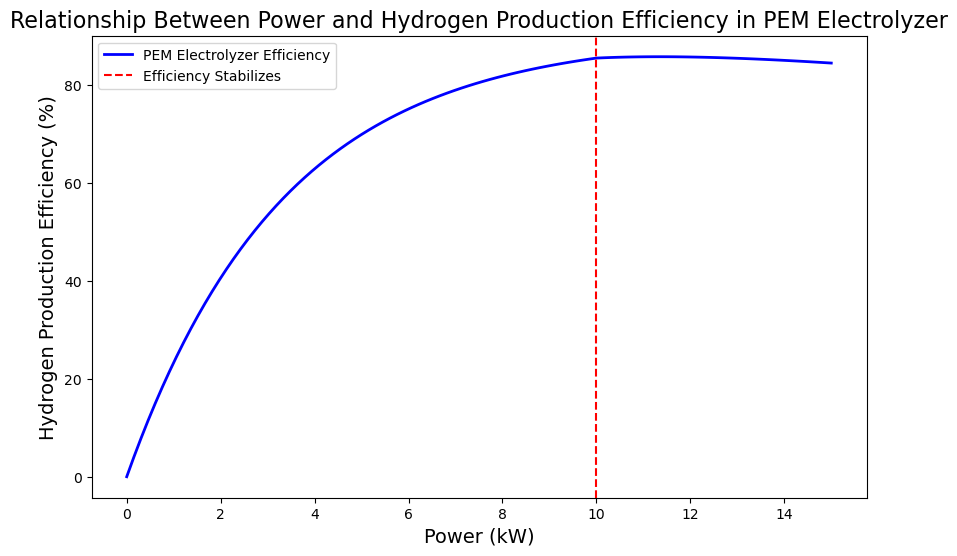

In [21]:
import matplotlib.pyplot as plt
import numpy as np


# 新的功率范围：0 到 15 kW
power = np.linspace(0, 15, 100)  # 功率范围（kW）

# 调整后的效率曲线：0-10 kW范围内效率上升，10-15 kW范围内基本持平或微降
efficiency = 90 * (1 - np.exp(-0.3 * power))  # 效率上升到最大值85%
efficiency = np.clip(efficiency - 0.9 * np.maximum(power - 10, 0), 0, 90)  # 10 kW之后效率持平或微降

# 创建图表
plt.figure(figsize=(10, 6))
plt.plot(power, efficiency, label="PEM Electrolyzer Efficiency", color='b', linewidth=2)

# 添加标签和标题
plt.xlabel("Power (kW)", fontsize=14)
plt.ylabel("Hydrogen Production Efficiency (%)", fontsize=14)
plt.title("Relationship Between Power and Hydrogen Production Efficiency in PEM Electrolyzer", fontsize=16)
# plt.grid(True)
plt.grid(False)

plt.axvline(x=10, color='r', linestyle='--', label='Efficiency Stabilizes')
plt.legend()

# 显示图表
plt.show()



In [23]:
import pandas as pd

# 创建数据表
data = pd.DataFrame({
    'Power (kW)': power,
    'Efficiency (%)': efficiency
})
# 保存为CSV文件
file_path = r'D:\a_study\博弈模型\图\PEM_Electrolyzer_Efficiency.csv'
data.to_csv(file_path, index=False)